### Import Packages

In [1]:
%config Completer.use_jedi = False
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio.v2 as imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE
from skimage import segmentation

import tensorflow as tf
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet
from keras.applications import VGG16, EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array, array_to_img
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

import warnings
warnings.simplefilter("ignore", UserWarning)

2023-05-30 22:51:26.550718: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-30 22:51:26.552416: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-30 22:51:26.586162: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-30 22:51:26.586715: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 22:51:27.192924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# Avoid OOM errors by setting memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
directory = r'./LungCancerDataset/The IQ-OTHNCCD lung cancer dataset'

categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

### Image Size Variations

In [4]:
size_data = {}
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1 
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1
    
    size_data[i] = temp_dict
        
size_data

{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '512 x 623': 31,
  '512 x 801': 28,
  '404 x 511': 1},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

Bengin cases


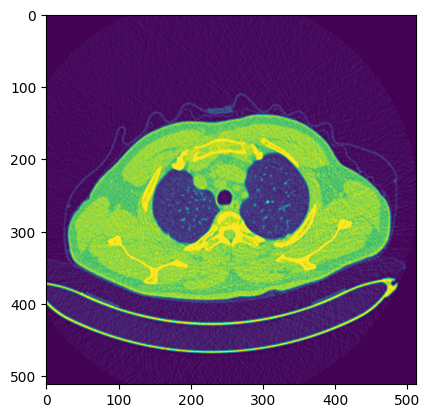

Malignant cases


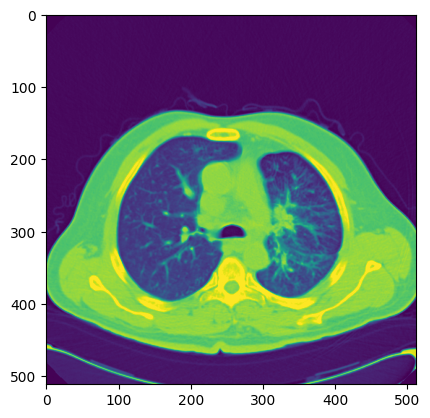

Normal cases


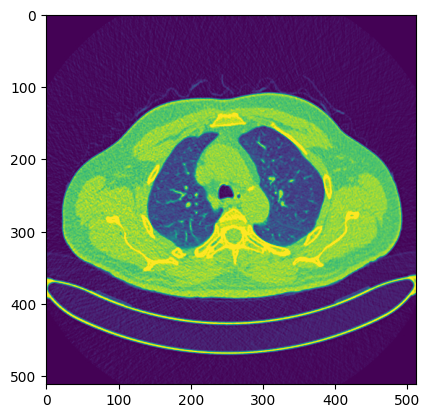

In [5]:
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

### Image Preprocessing and Testing

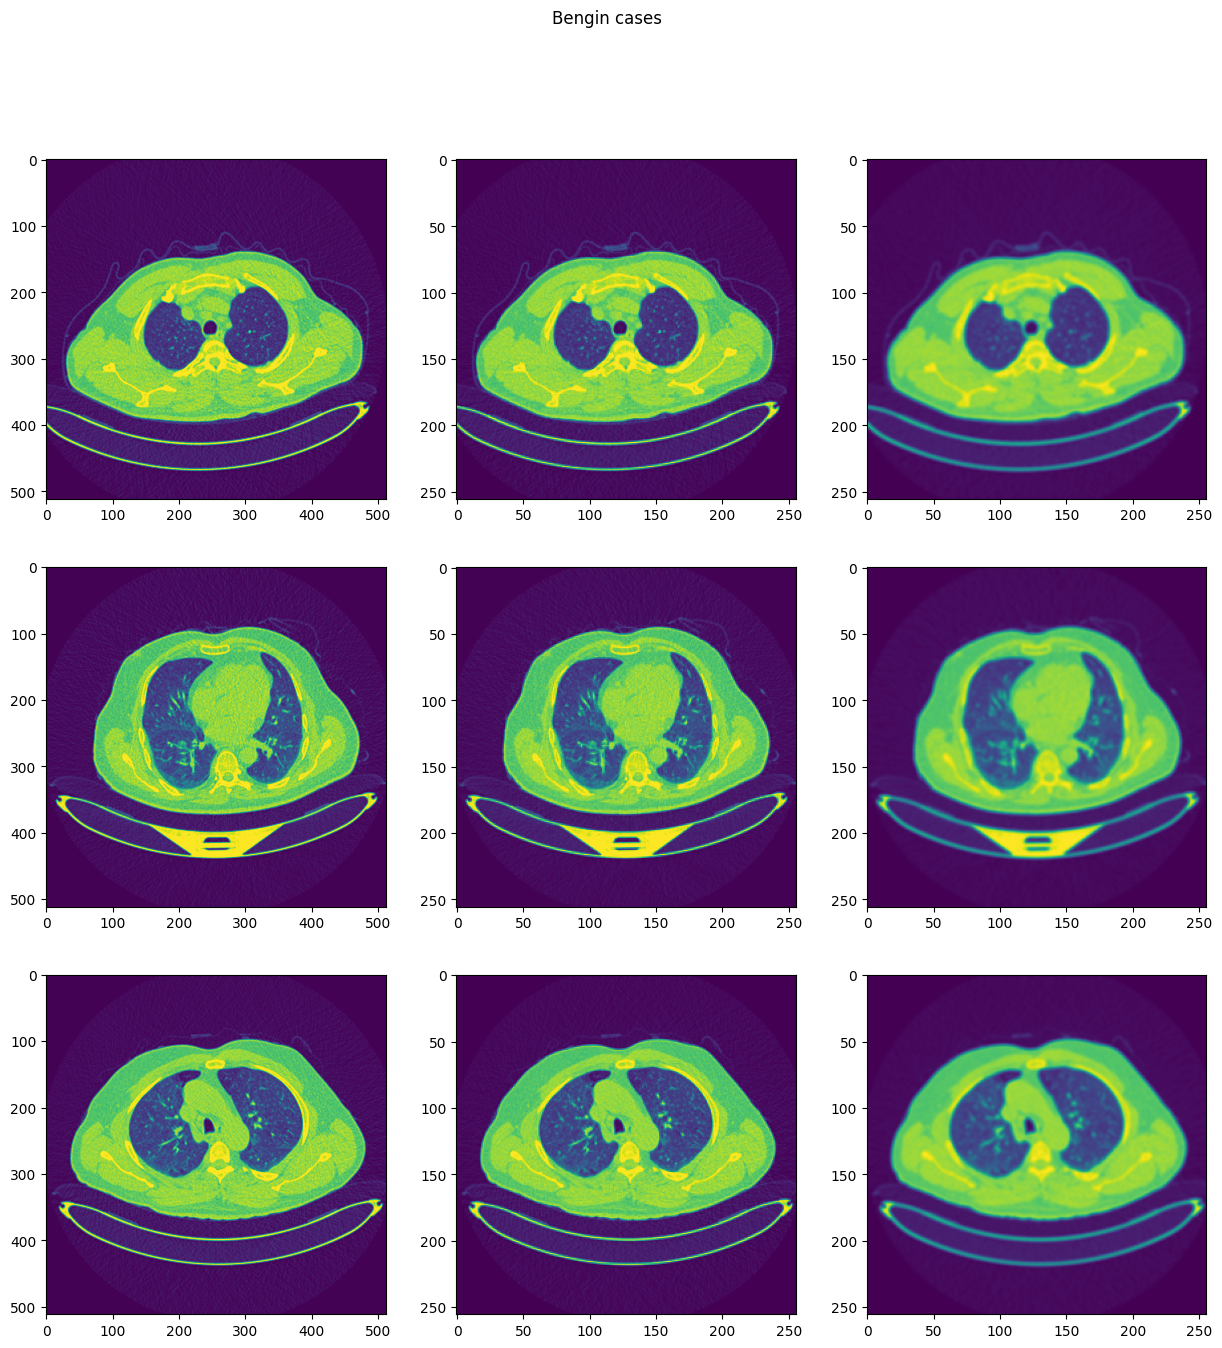

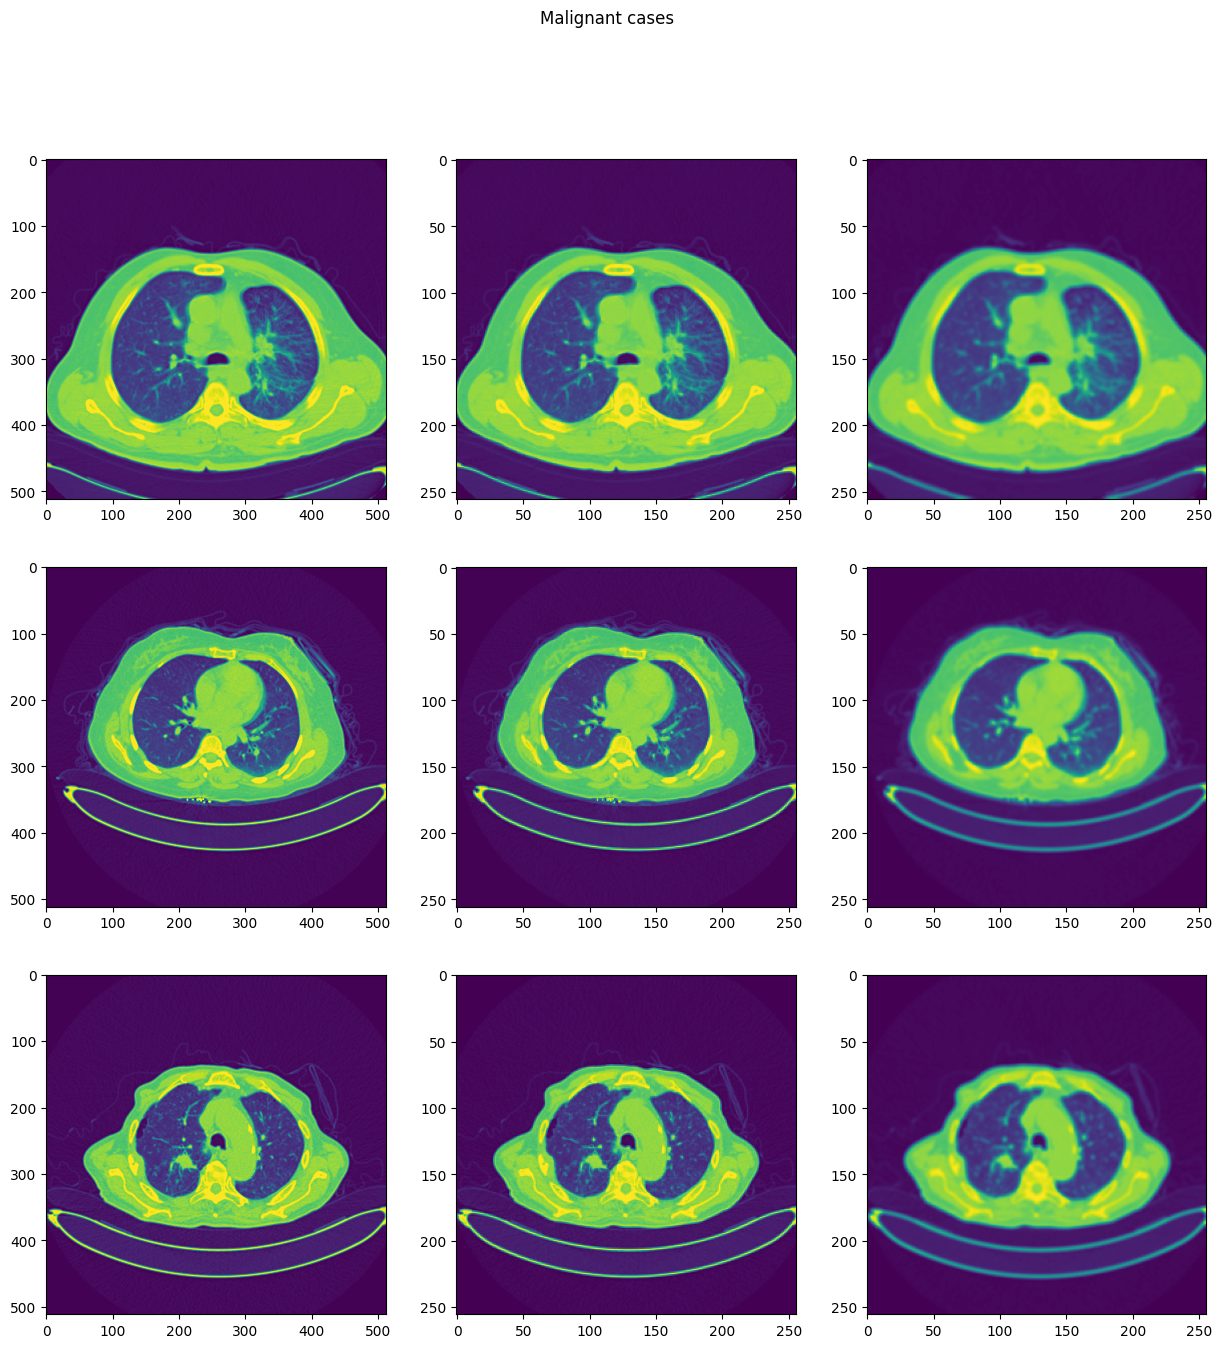

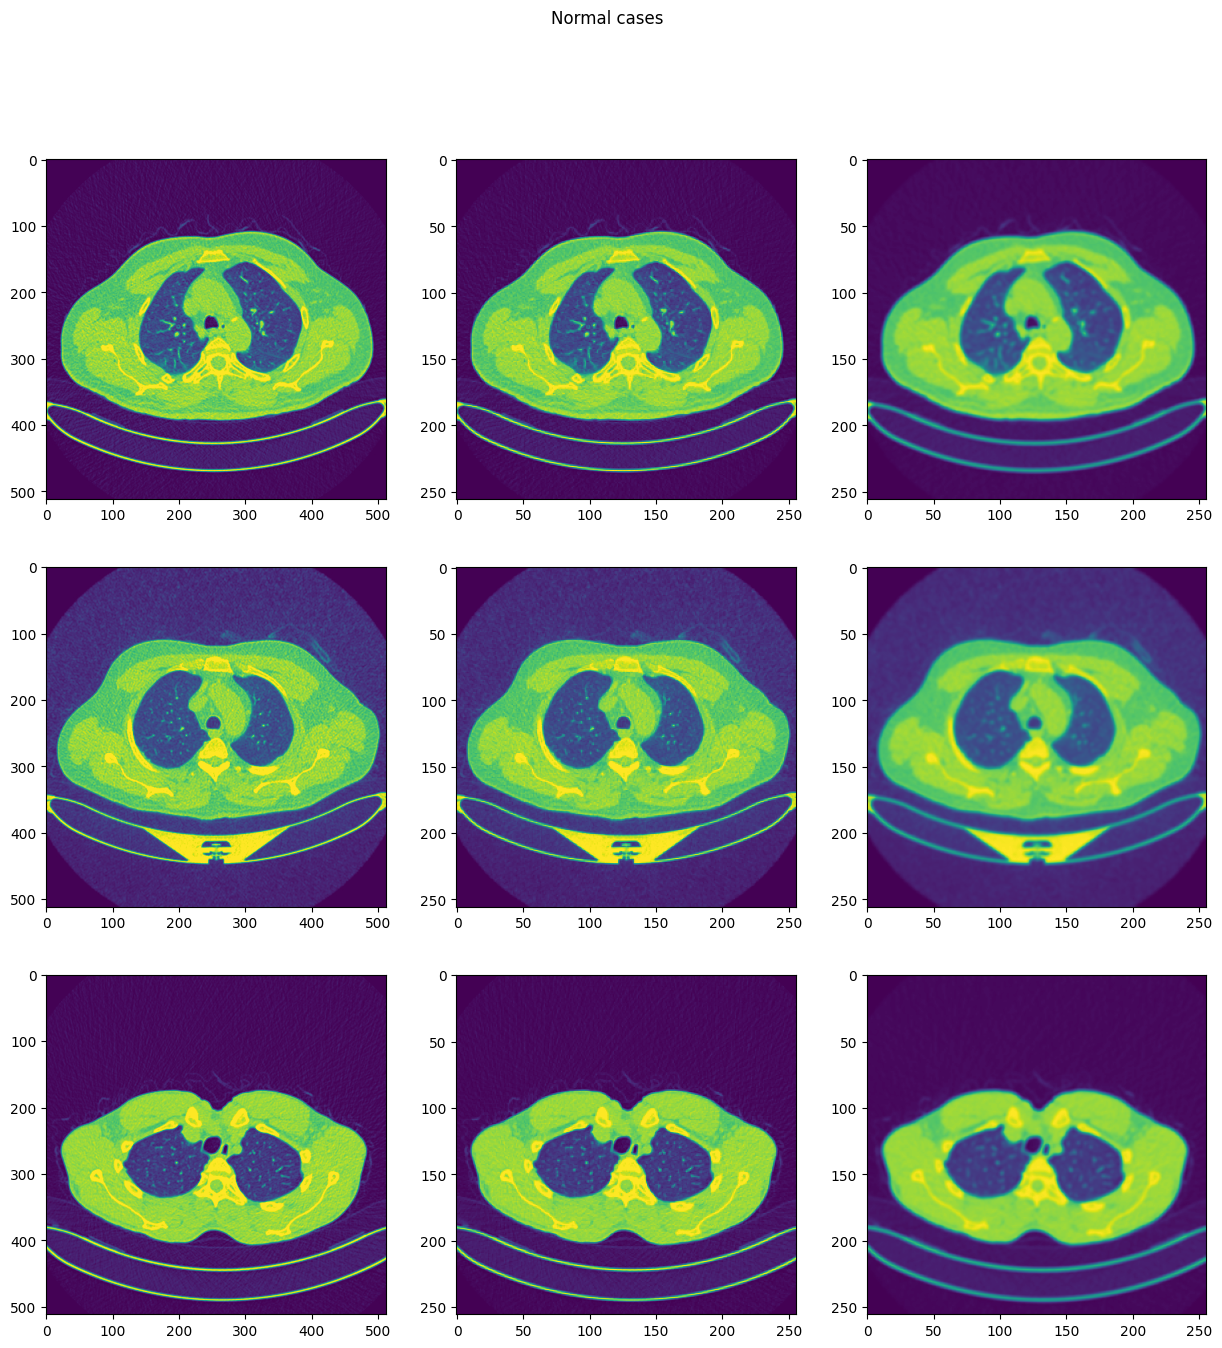

In [6]:
img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)
    
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        
        img0 = cv2.resize(img, (img_size, img_size))
        
        img1 = cv2.GaussianBlur(img0, (5, 5), 0)
        
        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break
        
plt.show()

### Preparing Data

In [7]:
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])
        
random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)
    
print('X length:', len(X))
print('y counts:', Counter(y))

# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=10, stratify=y)

print('Train length:', len(X_train), X_train.shape)
print('Test length:', len(X_valid), X_valid.shape)

Train length: 822 (822, 256, 256, 1)
Test length: 275 (275, 256, 256, 1)


### Applying SMOTE to oversample the data

In [9]:
print(Counter(y_train), Counter(y_valid))

Counter({1: 420, 2: 312, 0: 90}) Counter({1: 141, 2: 104, 0: 30})


In [10]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

print(len(X_train), X_train.shape)

822 (822, 256, 256, 1)
822 (822, 65536)


In [11]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({1: 420, 2: 312, 0: 90})
After SMOTE: Counter({2: 420, 1: 420, 0: 420})


In [12]:

X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

822 (822, 256, 256, 1)
1260 (1260, 256, 256, 1)


### **Model Building**

In [13]:
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

In [14]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=8, shuffle=True) 
validation_generator = val_datagen.flow(X_valid, y_valid, batch_size=8, shuffle=True)

In [15]:
# model = Sequential()

# model.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())
# model.add(Dense(16))
# model.add(Dense(3, activation='softmax'))

# model.summary()

In [16]:
# model = Sequential()

# model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=X_train.shape[1:]))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())
# model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# model.add(Dense(3, activation='softmax'))

# model.summary()

In [17]:
# VGG16
# Create an instance of the VGG16 model with pre-trained weights
vgg = VGG16(weights=None, include_top=False, input_shape=X_train_sampled.shape[1:])

# Freeze the convolutional layers in the base model so they are not updated during training
for layer in vgg.layers:
    layer.trainable = False

# Add your own classification layers on top of the base model
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14713536  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 23,103,171
Trainable params: 8,389,635
Non-trainable params: 14,713,536
_________________________________________________________________


In [18]:
# simple early stopping
callback = EarlyStopping(monitor='val_loss', patience=3)

In [19]:
# Compile the model with a lower learning rate and categorical hinge loss
opt = Adam(lr=0.0001)

In [20]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [21]:
history = model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[callback], shuffle=True)

Epoch 1/20


2023-05-30 22:51:38.310503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


103/103 [==============================] - ETA: 0s - loss: 1.0425 - accuracy: 0.5085

2023-05-30 22:55:18.067882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


103/103 [==============================] - 296s 3s/step - loss: 1.0425 - accuracy: 0.5085 - val_loss: 0.9953 - val_accuracy: 0.5127
Epoch 2/20
103/103 [==============================] - 308s 3s/step - loss: 0.9777 - accuracy: 0.5097 - val_loss: 0.9610 - val_accuracy: 0.5127
Epoch 3/20
103/103 [==============================] - 312s 3s/step - loss: 0.9566 - accuracy: 0.5109 - val_loss: 0.9516 - val_accuracy: 0.5127
Epoch 4/20
 17/103 [===>..........................] - ETA: 3:07 - loss: 0.9594 - accuracy: 0.5221

KeyboardInterrupt: 

### **Results**

In [ ]:
y_pred = model.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))
print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()